In [76]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests

In [77]:
API_KEY = "8b491b601812f2ddd75d2597"
API_BASE_URL = f"https://v6.exchangerate-api.com/v6/{API_KEY}/latest/USD"
rates = requests.get(API_BASE_URL).json()['conversion_rates']

In [78]:
users = pd.read_csv("./Datasets/users.csv")
purchases = pd.read_csv("./Datasets/purchases.csv")
purchases.head(5)

,user_id,SKU,AddedTime,Price,CurrencyISO
0,6192636,personal_offer_starter_pack,2023-01-31 13:16:55.991756+00:00,2.29,GBP
1,5954105,bundle_pack_1,2023-01-06 19:20:33.631714+00:00,1.79,EUR
2,5954105,coin_pack_1,2023-01-07 15:56:47.792655+00:00,0.79,EUR
3,5903715,bundle_pack_1,2023-01-01 18:48:38.391356+00:00,1.99,USD
4,5984323,golden_ticket_season_pass,2023-01-11 21:13:47.161073+00:00,9.99,USD


# Preprocessing

## Normalizing Prices to USD

In [79]:
purchases["PriceUSD"] = purchases.apply(lambda row : row["Price"] / rates[row["CurrencyISO"]], axis=1)
purchases.head(5)

,user_id,SKU,AddedTime,Price,CurrencyISO,PriceUSD
0,6192636,personal_offer_starter_pack,2023-01-31 13:16:55.991756+00:00,2.29,GBP,2.770050
1,5954105,bundle_pack_1,2023-01-06 19:20:33.631714+00:00,1.79,EUR,1.898801
2,5954105,coin_pack_1,2023-01-07 15:56:47.792655+00:00,0.79,EUR,0.838018
3,5903715,bundle_pack_1,2023-01-01 18:48:38.391356+00:00,1.99,USD,1.990000
4,5984323,golden_ticket_season_pass,2023-01-11 21:13:47.161073+00:00,9.99,USD,9.990000


## Join Tables

In [80]:
df = pd.merge(users,purchases,on="user_id")

In [81]:
df

,user_id,registered_time,country_code,SKU,AddedTime,Price,CurrencyISO,PriceUSD
0,6192636,2023-01-30 16:12:02.731706+01:00,GB,personal_offer_starter_pack,2023-01-31 13:16:55.991756+00:00,2.29,GBP,2.770050
1,5954105,2023-01-05 20:33:54.584158+01:00,BE,bundle_pack_1,2023-01-06 19:20:33.631714+00:00,1.79,EUR,1.898801
2,5954105,2023-01-05 20:33:54.584158+01:00,BE,coin_pack_1,2023-01-07 15:56:47.792655+00:00,0.79,EUR,0.838018
3,5903715,2022-12-30 18:47:41.108888+01:00,US,bundle_pack_1,2023-01-01 18:48:38.391356+00:00,1.99,USD,1.990000
4,5984323,2023-01-09 18:57:06.353154+01:00,US,golden_ticket_season_pass,2023-01-11 21:13:47.161073+00:00,9.99,USD,9.990000
...,...,...,...,...,...,...,...,...
1399,5964679,2023-01-07 00:50:45.364926+01:00,US,bundle_pack_1,2023-02-01 13:13:43.680081+00:00,1.49,USD,1.490000
1400,5964679,2023-01-07 00:50:45.364926+01:00,US,coin_pack_1,2023-01-19 13:51:50.503887+00:00,0.99,USD,0.990000
1401,5964679,2023-01-07 00:50:45.364926+01:00,US,bundle_pack_1,2023-02-04 23:15:25.865344+00:00,1.49,USD,1.490000
1402,5964679,2023-01-07 00:50:45.364926+01:00,US,coin_pack_1,2023-01-20 15:43:32.899227+00:00,0.99,USD,0.990000


# Data Visualization

## Plot The Daily Sales

<Axes: xlabel='PriceUSD', ylabel='AddedTime'>

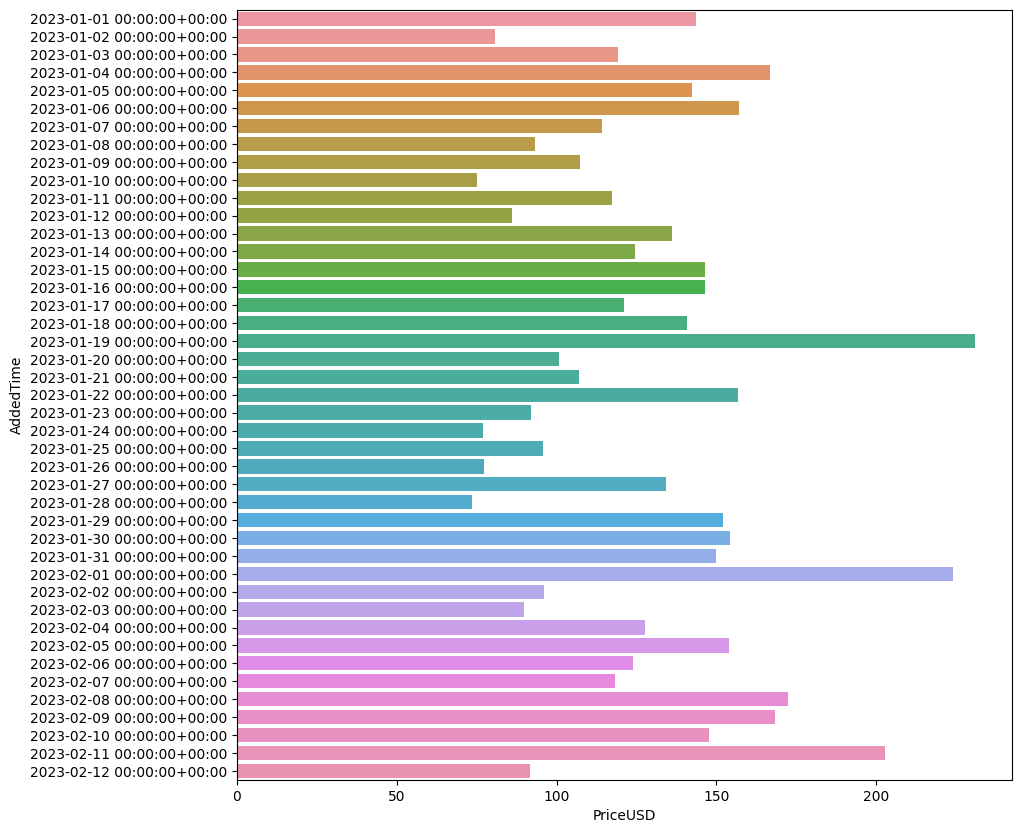

In [182]:
daily_sale = df.set_index("AddedTime").resample("D").sum("PriceUSD").reset_index()
plt.figure(figsize=(10,10))
sns.barplot(daily_sale, y="AddedTime",x="PriceUSD", orient="horizontal" )


## Plot Top 5 Sales Weekly

/tmp/ipykernel_1467/4189418465.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weekly_sum = df.set_index("AddedTime").resample("W-MON").sum().nlargest(5, columns=["PriceUSD"]).reset_index()


<Axes: xlabel='PriceUSD', ylabel='AddedTime'>

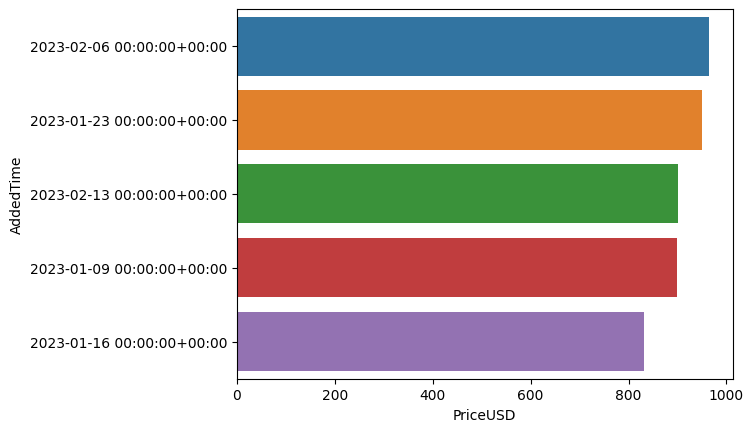

In [191]:
df["AddedTime"] = pd.to_datetime(df["AddedTime"])
weekly_sum = df.set_index("AddedTime").resample("W-MON").sum().nlargest(5, columns=["PriceUSD"]).reset_index()
sns.barplot(weekly_sum, x="PriceUSD", y="AddedTime", orient="horizontal")

## Sales Per WeekDays

<Axes: >

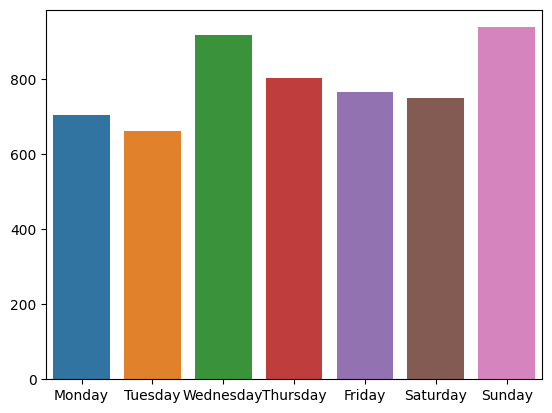

In [189]:
weekday_idx_sum = df.groupby(df["AddedTime"].dt.weekday).sum("PriceUSD")["PriceUSD"].to_dict()
weekday_map = {"0":  "Monday",
               "1" : "Tuesday",
               "2" : "Wednesday",
               "3" : "Thursday",
               "4" : "Friday",
               "5" : "Saturday",
               "6" : "Sunday"
               }
weekday_sum = {weekday_map[str(key)]: value for key,value in weekday_idx_sum.items()}
sns.barplot(x=list(weekday_sum.keys()), y=list(weekday_sum.values()))


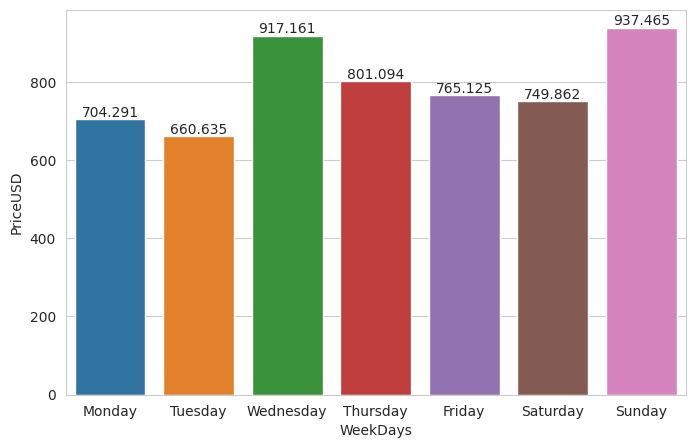

In [199]:
# A Better Way ;) 
weekday_idx_sum = df.groupby(df["AddedTime"].dt.weekday).sum("PriceUSD")
weekday_idx_sum["WeekDays"] = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
plt.figure(figsize=(8,5))
sns.set_style('whitegrid')
ax = sns.barplot(weekday_idx_sum , x="WeekDays" , y="PriceUSD")
for i in ax.containers:
    ax.bar_label(i,)


## The Country of The Customer with Highest Purchase Value

In [241]:
user_id = df.groupby("user_id").sum("PriceUSD").nlargest(5,columns="PriceUSD").index[0]
df.loc[df["user_id"] == user_id , 'country_code'].values[0]

'US'

## Count of Unique Buyers by Country

In [244]:
df.groupby("country_code")["user_id"].nunique().sort_values(ascending=False)

country_code
US    191
GB     37
AU     13
DE     13
CA     10
BE      4
PL      4
JP      3
NL      3
FR      3
DK      3
SE      2
ID      2
MY      1
RE      1
PH      1
TW      1
NO      1
SK      1
IT      1
MX      1
LK      1
IM      1
IL      1
HR      1
HK      1
GR      1
ES      1
CH      1
ZA      1
Name: user_id, dtype: int64

## Top 5 Countries based on PriceUSD

In [249]:
df.groupby("country_code").sum("PriceUSD").nlargest(5,columns=["PriceUSD"])

,user_id,Price,PriceUSD
country_code,,,
US,4723735251,4226.72,4226.720000
GB,774079965,314.15,380.004839
AU,428101264,374.30,249.084980
DE,261850850,202.69,207.483944
CA,345601320,177.43,129.199738


## Which Country has the best customers?

In [257]:
df.groupby("country_code").mean("PriceUSD").nlargest(5,columns=["PriceUSD"])

,user_id,Price,PriceUSD
country_code,,,
RE,6239061.0,10.990000,11.658004
IL,5935870.0,36.900000,10.080315
SE,5545225.5,69.000000,6.553516
NO,5374193.0,61.666667,5.727909
ES,5919498.0,4.990000,5.293306
